In [1]:
from datasets import load_from_disk, concatenate_datasets
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Data Cleaning & Preprocessing

Function to execute all data cleaning processes. 

In [4]:
def load_and_process_categories(base_path, category):
    review_path = os.path.join(base_path, f"raw_review_{category}")
    meta_path = os.path.join(base_path, f"raw_meta_{category}")

    review_data = load_from_disk(review_path)
    meta_data = load_from_disk(meta_path)

    #convert to pandas Dataframe
    review_df = review_data["full"].to_pandas()
    meta_df = meta_data["full"].to_pandas()

    # Merge on parent_asin
    merged_df = pd.merge(review_df, meta_df, on="parent_asin", how="left")

    #Function to drop rows where rating is missing or not in [1–5], drop rows if text (the review body) is empty or null
    merged_df = merged_df[merged_df["rating"].between(1, 5)]
    merged_df = merged_df[merged_df["text"].notnull() & (merged_df["text"].str.strip() != "")]

    def get_brand(details, store):
        if isinstance(details, dict) and "brand" in details:
            return details["brand"]
        return store if store else "Unknown"

    merged_df["brand"] = merged_df.apply(lambda row: get_brand(row.get("details", {}), row.get("store")), axis=1)

    # Remove duplicates
    merged_df.drop_duplicates(subset=["user_id", "asin", "text"], keep="first", inplace=True)

    # Derived columns
    merged_df["review_length"] = merged_df["text"].str.split().str.len()
    merged_df["year"] = pd.to_datetime(merged_df["timestamp"], unit="ms", errors="coerce").dt.year

    return merged_df

In [5]:
from bigdata_a3_utils import VALID_CATEGORIES
all_dfs = []

merged_df = load_and_process_categories("./review_files", VALID_CATEGORIES[0])

In [6]:
merged_df.tail(5)

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,videos,store,categories,details,bought_together,subtitle,author,brand,review_length,year
701523,4.0,Four Stars,Conditioner is great shampoo not as I expected,[],B006YUIWKA,B006YUIWKA,AFIXGFVEGLMOTMBTJL7H3VSIETDQ,1478227021000,0,True,...,{'title': ['Celluplex Thicker Fuller Hair Seru...,Thicker Fuller Hair,[],"{""Item Form"": ""Liquid"", ""Brand"": ""Thicker Full...",None,None,None,Thicker Fuller Hair,8,2016
701524,1.0,Pretty,Did not work! Used the whole bottle and my hai...,[],B006YUIWKA,B006YUIWKA,AFV7YZFOJF564EZGET5LG45K4QEA,1480908730000,0,False,...,{'title': ['Celluplex Thicker Fuller Hair Seru...,Thicker Fuller Hair,[],"{""Item Form"": ""Liquid"", ""Brand"": ""Thicker Full...",None,None,None,Thicker Fuller Hair,14,2016
701525,5.0,Great sunless tanner,Product as expected. Shipping was on time.,[],B06ZZV9MZT,B06ZZV9MZT,AHYDCWDMMVMLBX7FY7M7JKADKRDQ,1590547974067,0,True,...,"{'title': [], 'url': [], 'user_id': []}",Pharmapacks,[],"{""Item Form"": ""Spray"", ""Skin Type"": ""All"", ""Br...",None,None,None,Pharmapacks,7,2020
701526,5.0,The Crown on top is a Ring!!!,"Not only is it a delicious fragrance, but also...",[],B000HB6VLE,B000HB6VLE,AF6ZIAEN7TQ2WY5ZL77F6JDPV7XQ,1184798209000,4,False,...,"{'title': [], 'url': [], 'user_id': []}",None,[],{},None,None,None,Unknown,33,2007
701527,4.0,Good Shampoo/Conditioner,The conditioner doesn't really make your hair ...,[],B0093MXHFG,B0093MXHFG,AGIYQU6RK6TBKBCMWKVPBPBMMJNA,1366944486000,1,True,...,"{'title': [], 'url': [], 'user_id': []}",Iden,[],"{""Product Benefits"": ""Massage,Color Safe,Nouri...",None,None,None,Iden,47,2013


In [7]:
merged_df.dtypes

rating               float64
title_x               object
text                  object
images_x              object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
main_category         object
title_y               object
average_rating       float64
rating_number          int64
features              object
description           object
price                 object
images_y              object
videos                object
store                 object
categories            object
details               object
bought_together       object
subtitle              object
author                object
brand                 object
review_length          int64
year                   int32
dtype: object

In [10]:
#Output of the total reviews from each year
print(merged_df["year"].value_counts().sort_index())

year
2000         1
2001        11
2002        24
2003        56
2004       130
2005       265
2006       416
2007      1150
2008      1251
2009      1198
2010      1568
2011      1855
2012      2774
2013      7882
2014     16107
2015     35844
2016     62042
2017     67351
2018     71966
2019     98148
2020    125427
2021    123279
2022     60654
2023     14148
Name: count, dtype: int64


## Unified Output

# Exploratory Data Analysis (EDA)

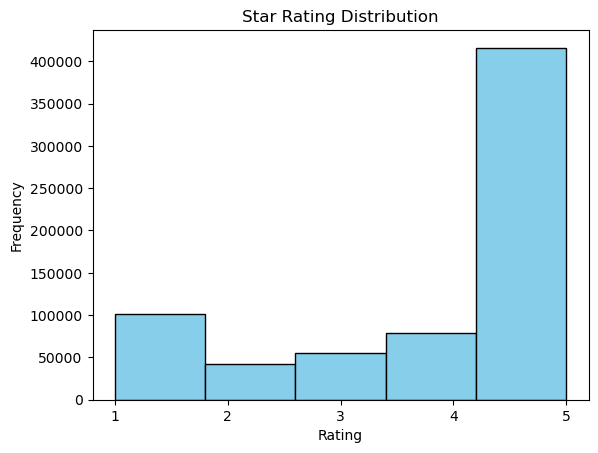

In [15]:
#Star Rating Histogram
plt.hist(merged_df['rating'], bins=5, range=(1, 5), edgecolor='black', color='skyblue')
plt.title('Star Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.show()

In [ ]:
#Bar chart showing top 10 categories

#Group by category and count the reviews
top_categories = merged_df['categories'].value_counts().head(10)

# Plot the bar chart
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top 10 Categories by Review Count')
plt.xlabel('Review Count')
plt.ylabel('Category')
plt.show()

C:\Users\student\AppData\Local\Temp\ipykernel_14344\1790700790.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')


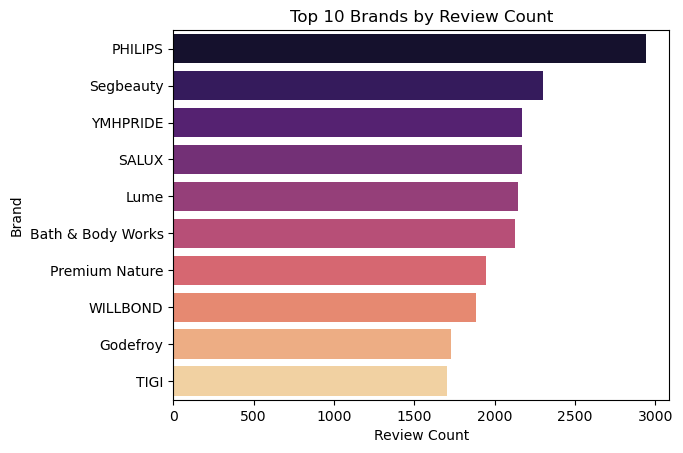

In [27]:
#Bar chart showing top 10 brands (excluding "Unknown")

#Filter out "Unknown" and count reviews by brand
top_brands = merged_df[merged_df['brand'] != "Unknown"]['brand'].value_counts().head(10)

# Plot the bar chart
sns.barplot(x=top_brands.values, y=top_brands.index, palette='magma')
plt.title('Top 10 Brands by Review Count')
plt.xlabel('Review Count')
plt.ylabel('Brand')
plt.show()

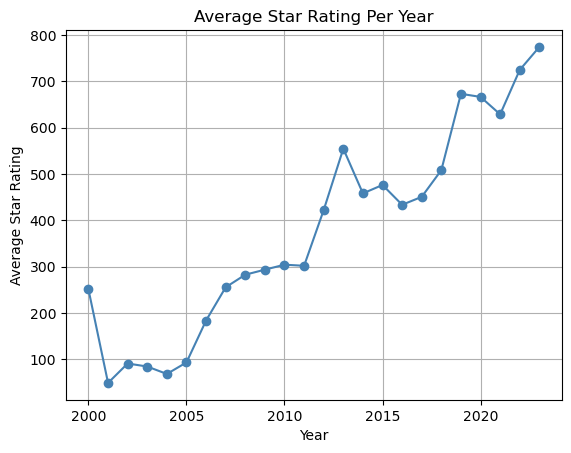

In [29]:
#Line chart of average star rating per year

#Group by year and calculate average star rating
time_trend = merged_df.groupby('year')['rating_number'].mean()

# Plot the line chart
plt.plot(time_trend.index, time_trend.values, marker='o', color='steelblue')
plt.title('Average Star Rating Per Year')
plt.xlabel('Year')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.show()

In [33]:
#Calculate Pearson correlation
correlation = merged_df['review_length'].corr(merged_df['rating'], method='pearson')

#Print correlation result
print(f"Pearson Correlation between Review Length and Star Rating: {correlation:.2f}")

Pearson Correlation between Review Length and Star Rating: -0.02


# Binary Sentiment Prediction (Logistic Regression)

In [59]:
# Importing the relevant libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [61]:
# Creating sentiment column in dataframe
merged_df["sentiment"] = merged_df["rating"].apply(lambda x: 1 if x > 3 else 0)

In [63]:
merged_df.head(10)

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,store,categories,details,bought_together,subtitle,author,brand,review_length,year,sentiment
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True,...,HERBIVORE,[],"{""Hair Type"": ""Wavy"", ""Material Type Free"": ""D...",None,None,None,HERBIVORE,61,2020,1
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True,...,Two Goats Apothecary,[],"{""Brand"": ""Two Goats Apothecary"", ""Item Form"":...",None,None,None,Two Goats Apothecary,47,2020,1
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True,...,New Road Beauty,[],"{""Package Dimensions"": ""10.5 x 6.4 x 1.6 inche...",None,None,None,New Road Beauty,4,2020,1
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True,...,muaowig,[],"{""Brand"": ""muaowig"", ""Material"": ""Human Hair"",...",None,None,None,muaowig,2,2022,0
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True,...,Yinhua,[],"{""Package Dimensions"": ""8.5 x 3.82 x 2.24 inch...",None,None,None,Yinhua,2,2020,1
5,4.0,Pretty Color,The polish was quiet thick and did not apply s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B00R8DXL44,B00R8DXL44,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,1598567408138,0,True,...,China Glaze,[],"{""Brand"": ""China Glaze"", ""Item Form"": ""Liquid""...",None,None,None,China Glaze,24,2020,1
6,5.0,Handy,Great for many tasks. I purchased these for m...,[],B099DRHW5V,B099DRHW5V,AHREXOGQPZDA6354MHH4ETSF3MCQ,1631885519443,0,True,...,AYQNMHR,[],"{""Package Dimensions"": ""8.58 x 4.37 x 3.27 inc...",None,None,None,AYQNMHR,22,2021,1
7,3.0,Meh,These were lightweight and soft but much too s...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B088SZDGXG,B08BBQ29N5,AEYORY2AVPMCPDV57CE337YU5LXA,1634275259292,0,True,...,Niseyo,[],"{""Brand"": ""Niseyo"", ""Extension Length"": ""24 In...",None,None,None,Niseyo,32,2021,0
8,5.0,Great for at home use and so easy to use!,This is perfect for my between salon visits. I...,[],B08P2DZB4X,B08P2DZB4X,AFSKPY37N3C43SOI5IEXEK5JSIYA,1627391044559,0,False,...,Nira,[],"{""Skin Type"": ""Dry"", ""Product Benefits"": ""Hydr...",None,None,None,Nira,72,2021,1
9,5.0,Nice shampoo for the money,I get Keratin treatments at the salon at least...,[],B086QY6T7N,B086QY6T7N,AFSKPY37N3C43SOI5IEXEK5JSIYA,1626614511145,0,False,...,Caroline Keller,[],"{""Brand"": ""Caroline Keller"", ""Item Form"": ""Liq...",None,None,None,Caroline Keller,89,2021,1


In [65]:
# Defining training model
model = LogisticRegression()

#Train, Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(merged_df["text"], merged_df["sentiment"], test_size=0.2, random_state=42)

In [67]:
vectorizer = TfidfVectorizer(lowercase=True, min_df=5, max_df=0.8, stop_words="english")

In [69]:
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [70]:
# Model Training
model.fit(X_train_vector, y_train)

LogisticRegression()

In [73]:
prediction = model.predict(X_test_vector)

In [77]:
# Evaluation

accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
confusion = confusion_matrix(y_test, prediction)

In [85]:
# Output of Results
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(confusion)

Accuracy: 0.88
F1 Score: 0.92

Confusion Matrix:
[[29313 10514]
 [ 6094 92789]]
